In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import os
import pickle
import re
from datetime import datetime as dt

from tqdm import tqdm
from tqdm import tnrange
from tqdm import tqdm_notebook

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm
import statsmodels.api as sm
from pandas.tools.plotting import autocorrelation_plot
from dateutil.relativedelta import relativedelta
from datetime import datetime as dt
from datetime import timedelta

from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing

### Weather Data

In [243]:
with open('processed_weather.pkl', 'rb') as f:
    weather_df = pickle.load(f)

In [244]:
# Set index to measurement time and sort
weather_df = weather_df.set_index('MeasurementTime')
weather_df = weather_df.sort_index()

# Subset on 2015-2017
weather_df = weather_df[weather_df.index >= dt.strptime("2015-01-01", "%Y-%m-%d")]
weather_df = weather_df[weather_df.index < dt.strptime("2018-01-01", "%Y-%m-%d")]

# 
weather_df = weather_df[~weather_df.TempC.isna()]
weather_df = weather_df.convert_objects(convert_numeric=True)

# Fix swapped temperature columns
weather_df = weather_df.rename(columns={'TempC': 'TempF', 'TempF': 'TempC'})

# Limit index to hour
weather_df.index = pd.to_datetime(weather_df.index.strftime("%Y-%m-%d %H"))

/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


In [245]:
def encode_weather(weather):
    
    joined = ''.join(weather).replace(',', '')
    l.append(joined)
    if len(joined) == 0:
        return 1       
    else:
        heavy = re.compile('[\w\s]*heavy[\w\s]*', flags=re.I)
        moderate = re.compile('[\w\s]*(rain|snow|ice)[\w\s]*', flags=re.I)
        light = re.compile('[\w\s]*(mist|drizzle)[\w\s]*', flags=re.I)
        if len(heavy.findall(joined)) > 0:
            return 4
        elif len(moderate.findall(joined)) > 0:
            return 3
        elif len(light.findall(joined)) > 0:
            return 2
        else: 
            return 1
        
weather_df['Weather'] = weather_df.WeatherText.apply(encode_weather)

In [246]:
weather_df.head()

,ReportType,SkyConditions,Visibility,WeatherType,TempF,TempC,Humidity,WindSpeed,WindDirection,Pressure,PressureTendency,PressureChange,Precip,SkyText,WeatherText,Weather
2015-01-01 00:00:00,FM-15,SCT:04 65,10.0,NaN,22.0,-5.6,50.0,10.0,220.0,30.07,8.0,NaN,0.0,Scattered,"[, , ]",1
2015-01-01 01:00:00,FM-15,FEW:02 65 BKN:07 180,10.0,NaN,22.0,-5.6,50.0,10.0,230.0,30.05,NaN,NaN,0.0,Broken,"[, , ]",1
2015-01-01 02:00:00,FM-15,BKN:07 150 BKN:07 200,10.0,NaN,22.0,-5.6,50.0,11.0,230.0,30.03,NaN,NaN,0.0,Broken,"[, , ]",1
2015-01-01 03:00:00,FM-15,SCT:04 130 BKN:07 170,10.0,NaN,24.0,-4.4,46.0,13.0,240.0,30.01,6.0,NaN,0.0,Broken,"[, , ]",1
2015-01-01 04:00:00,FM-15,CLR:00,10.0,NaN,22.0,-5.6,52.0,15.0,230.0,30.00,NaN,NaN,0.0,Clear,"[, , ]",1


In [247]:
# Select columns of interest
weather_cols = ['Weather', 'TempF', 'TempC', 'WindSpeed', 'WindDirection', 'Pressure', 'Precip']
weather_df = weather_df[weather_cols]
weather_df.head()

,Weather,TempF,TempC,WindSpeed,WindDirection,Pressure,Precip
2015-01-01 00:00:00,1,22.0,-5.6,10.0,220.0,30.07,0.0
2015-01-01 01:00:00,1,22.0,-5.6,10.0,230.0,30.05,0.0
2015-01-01 02:00:00,1,22.0,-5.6,11.0,230.0,30.03,0.0
2015-01-01 03:00:00,1,24.0,-4.4,13.0,240.0,30.01,0.0
2015-01-01 04:00:00,1,22.0,-5.6,15.0,230.0,30.00,0.0


In [248]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26285 entries, 2015-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 7 columns):
Weather          26285 non-null int64
TempF            26282 non-null float64
TempC            26282 non-null float64
WindSpeed        26278 non-null float64
WindDirection    25924 non-null float64
Pressure         26239 non-null float64
Precip           24364 non-null float64
dtypes: float64(6), int64(1)
memory usage: 2.9 MB


### Trip Data

In [258]:
with open('start.pkl', 'rb') as f:
    start_df = pickle.load(f)

In [259]:
# Add work day to df
start_df['WorkDay'] = (start_df.index.weekday < 6) * 1

# Encode user type
start_df.UserType = start_df.UserType.map({'Member': 1, 'Casual': 2})

In [260]:
def get_season(doy):
    # "day of year" ranges for the northern hemisphere
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    # winter = everything else

    if doy in spring:
        season = 'Spring'
    elif doy in summer:
        season = 'Summer'
    elif doy in fall:
        season = 'Fall'
    else:
        season = 'Winter'
    return season

start_df['Season'] = [get_season(xi) for xi in start_df.index.dayofyear]

In [261]:
# Add MA holidays
from workalendar.usa import Massachusetts

cal = Massachusetts()
ma_holidays = []
for yr in [2015, 2016, 2017]:
    yr_holidays = cal.holidays(yr)
    yr_holidays = [x[0] for x in yr_holidays]
    ma_holidays += yr_holidays
    
# Designate Holidays
start_df['Holiday'] = 0    
idx_date = start_df.index.date
for hdate in ma_holidays:
    idx = (idx_date == hdate)
    start_df.loc[idx, 'Holiday'] = 1

In [262]:
start_df.head()

,Duration,BikeID,UserType,BirthYear,ID,Name,Lat,Lon,Year,Month,Week,Day,Hour,Quarter,DayOfWeek,WorkDay,Season,Holiday
Time,,,,,,,,,,,,,,,,,,
2015-01-01 00:21:44,542,277,1,1984,115,Porter Square Station,42.387995,-71.119084,2015,1,1,1,0,1,3,1,Winter,1
2015-01-01 00:27:03,438,648,1,1985,80,MIT Stata Center at Vassar St / Main St,42.361962,-71.092053,2015,1,1,1,0,1,3,1,Winter,1
2015-01-01 00:31:31,254,555,1,1974,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,2015,1,1,1,0,1,3,1,Winter,1
2015-01-01 00:53:46,432,1307,1,1987,115,Porter Square Station,42.387995,-71.119084,2015,1,1,1,0,1,3,1,Winter,1
2015-01-01 01:07:06,735,177,2,1986,105,Lower Cambridgeport at Magazine St/Riverside Rd,42.356954,-71.113687,2015,1,1,1,1,1,3,1,Winter,1


In [55]:
start_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3627543 entries, 2015-01-01 00:21:44 to 2017-12-31 23:46:18
Data columns (total 18 columns):
Duration     int64
BikeID       int64
UserType     object
BirthYear    object
ID           int64
Name         object
Lat          float64
Lon          float64
Year         int64
Month        int64
Week         int64
Day          int64
Hour         int64
Quarter      int64
DayOfWeek    int64
WorkDay      int64
Season       int64
Holiday      int64
dtypes: float64(2), int64(13), object(3)
memory usage: 685.8+ MB


### Resampling Data

In [56]:
R_hour = start_df.BikeID.resample('H').count()
R_hour.name = 'Count'

In [57]:
R_weather = weather_df.resample('H').mean()

In [58]:
R_weather.head()

,Visibility,TempF,TempC,Humidity,WindSpeed,WindDirection,Pressure,PressureTendency,PressureChange,Precip
2015-01-01 00:00:00,10.0,22.0,-5.6,50.0,10.0,220.0,30.07,8.0,NaN,0.0
2015-01-01 01:00:00,10.0,22.0,-5.6,50.0,10.0,230.0,30.05,NaN,NaN,0.0
2015-01-01 02:00:00,10.0,22.0,-5.6,50.0,11.0,230.0,30.03,NaN,NaN,0.0
2015-01-01 03:00:00,10.0,24.0,-4.4,46.0,13.0,240.0,30.01,6.0,NaN,0.0
2015-01-01 04:00:00,10.0,22.0,-5.6,52.0,15.0,230.0,30.00,NaN,NaN,0.0


In [64]:
data_df = pd.concat([R_hour, R_weather], axis=1)

In [65]:
data_df.head()

,Count,Visibility,TempF,TempC,Humidity,WindSpeed,WindDirection,Pressure,PressureTendency,PressureChange,Precip
Time,,,,,,,,,,,
2015-01-01 00:00:00,4,10.0,22.0,-5.6,50.0,10.0,220.0,30.07,8.0,NaN,0.0
2015-01-01 01:00:00,3,10.0,22.0,-5.6,50.0,10.0,230.0,30.05,NaN,NaN,0.0
2015-01-01 02:00:00,1,10.0,22.0,-5.6,50.0,11.0,230.0,30.03,NaN,NaN,0.0
2015-01-01 03:00:00,0,10.0,24.0,-4.4,46.0,13.0,240.0,30.01,6.0,NaN,0.0
2015-01-01 04:00:00,1,10.0,22.0,-5.6,52.0,15.0,230.0,30.00,NaN,NaN,0.0


In [66]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2015-01-01 00:00:00 to 2017-12-31 23:00:00
Freq: H
Data columns (total 11 columns):
Count               26304 non-null int64
Visibility          26244 non-null float64
TempF               26284 non-null float64
TempC               26284 non-null float64
Humidity            26282 non-null float64
WindSpeed           26277 non-null float64
WindDirection       25923 non-null float64
Pressure            26239 non-null float64
PressureTendency    8742 non-null float64
PressureChange      3 non-null float64
Precip              24364 non-null float64
dtypes: float64(10), int64(1)
memory usage: 3.7 MB


### With StatsModels

In [161]:
endog = data_df.Count.resample('W').sum()
exog = data_df[['Visibility', 'TempC', 'Humidity', 'WindSpeed', 'Pressure']].resample('W').mean()

In [162]:
endog.shape

(157,)

In [163]:
exog.shape

(157, 5)

                           Statespace Model Results                           
Dep. Variable:                  Count   No. Observations:                  157
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1485.929
Date:                Thu, 29 Mar 2018   AIC                           2987.859
Time:                        17:20:07   BIC                           3012.309
Sample:                    01-04-2015   HQIC                          2997.789
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     40.2055    276.788      0.145      0.885    -502.289     582.700
Visibility   463.9826    477.951      0.971      0.332    -472.783    1400.748
TempC        564.3899     71.956      7.844      0.0

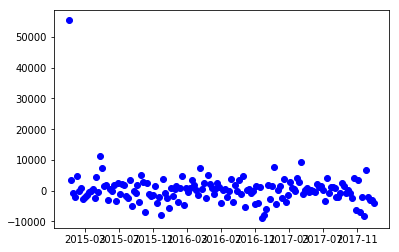

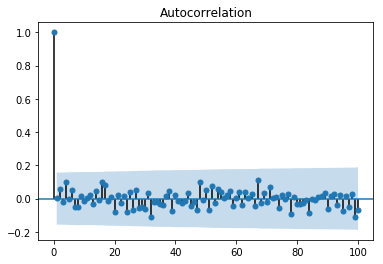

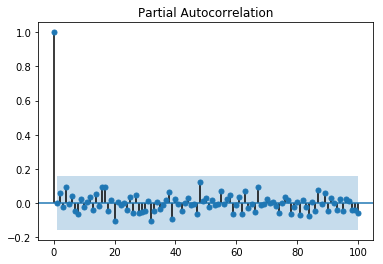

In [170]:
sarima_week = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(0,1,1), seasonal_order=(0,0,0,52), trend='c').fit()

print(sarima_week.summary())

plt.plot(sarima_week.resid, "bo")
print(plot_acf(sarima_week.resid, lags=100))
print(plot_pacf(sarima_week.resid, lags=100))

### With Prophet

In [68]:
# Python
import pandas as pd
import numpy as np
from fbprophet import Prophet

In [124]:
df1 = data_df.Count.resample('D').sum()
df = df1.copy()
# df2 = data_df.TempC.resample('D').mean()
# df = pd.concat([df1, df2], axis=1)

In [125]:
df = df.reset_index()
df = df.rename(columns={'Time': 'ds', 'Count': 'y'})
df.head()

,ds,y
0,2015-01-01,127
1,2015-01-02,213
2,2015-01-03,142
3,2015-01-04,112
4,2015-01-05,337


In [126]:
# df.loc[df.TempC.isna(), 'TempC'] = df.TempC.mean()

In [127]:
m = Prophet(interval_width=0.95)
# m.add_regressor('TempC')
m.fit(df);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [128]:
future = m.make_future_dataframe(periods=365)
# future_temp = np.random.uniform(df.TempC.min(), df.TempC.max(), size=future.shape)
# future['TempC'] = future_temp
future.tail()

,ds
1456,2018-12-27
1457,2018-12-28
1458,2018-12-29
1459,2018-12-30
1460,2018-12-31


In [129]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1456,2018-12-27,1949.601372,267.285415,3544.323356
1457,2018-12-28,1738.912540,15.823161,3507.899356
1458,2018-12-29,911.274476,-750.818320,2636.118388
1459,2018-12-30,669.534683,-1125.394004,2259.384896
1460,2018-12-31,1490.472946,-139.793721,3154.397297


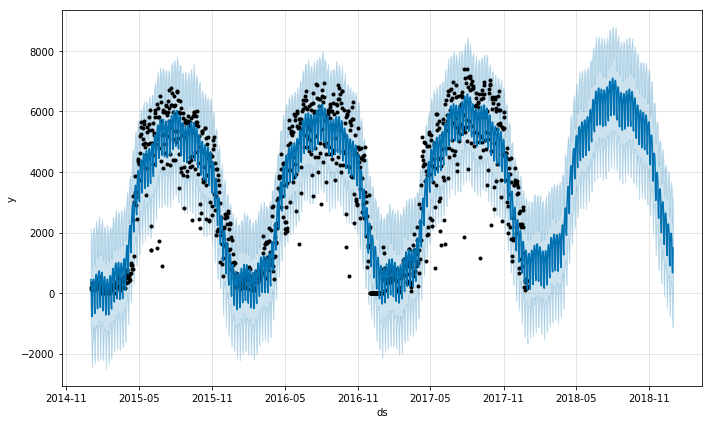

In [130]:
m.plot(forecast);

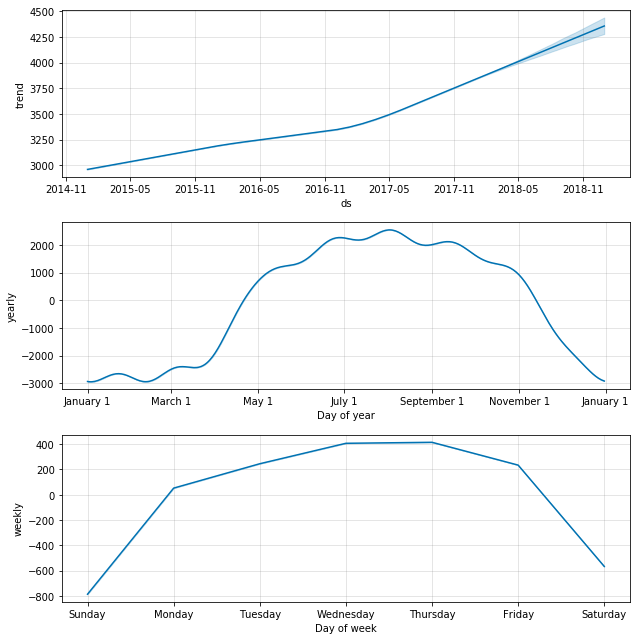

In [131]:
m.plot_components(forecast);